# Vision Transformers on UTKFace

In [ ]:
row=19
logger = True
pretrained = False

In [ ]:
# import argparse

# # Parse command-line arguments
# parser = argparse.ArgumentParser(description="Process some rows.")
# parser.add_argument("--row", type=int, default=0, help="Row index (default: 0)")
# parser.add_argument("--logger", type=bool, default=False, help="Print Log (default: False)")
# parser.add_argument("--pretrained", type=str, default='True', help="Pretrained (default: False)")
# args = parser.parse_args()

# # Assign the parsed value to the row variable
# row = args.row
# logger = args.logger
# pretrained = args.pretrained == "True"

# # Use the row variable as needed
# print(f"Row value is: {row}")
# print(pretrained)

## Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

import torchvision
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
# from torch.utils.data.sampler import SubsetRandomSampler

import torchvision.models as models

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

from datetime import datetime
import os

In [ ]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if logger:
    print("You are using device: %s" % device)

You are using device: cuda


## Dataset

In [ ]:
os.getcwd()

'/content'

In [ ]:
if logger:
    from google.colab import drive

    drive.mount('/content/drive')

    input_path = "/content/dataset/"
    if pretrained:
        path = '/content/drive/MyDrive/PD/pretrained/'
    else:
        path = '/content/drive/MyDrive/PD/no_pretrained/'

    import zipfile

    zip_ref = zipfile.ZipFile("/content/drive/MyDrive/PD/data/utk_crop.zip", 'r')
    zip_ref.extractall(input_path)
    zip_ref.close()
else:
    input_path = "data/"
    path = 'pretrained/' if pretrained else 'no_pretrained/'

Mounted at /content/drive


In [ ]:
classes = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Others"}
class_to_index = {v: k for k, v in classes.items()}
def reload_data(DATA_PATH, classes):
    age_list = []
    gender_list = []
    race_list = []
    datetime_list = []
    filename_list = []

    for filename in os.listdir(DATA_PATH):

        args = filename.split("_")

        if len(args)<4:
            age = int(args[0])
            gender = int(args[1])
            race = 4
            datetime = args[2].split(".")[0]
        else:
            age = int(args[0])
            gender = int(args[1])
            race = int(args[2])
            datetime = args[3].split(".")[0]
        age_list.append(age)
        gender_list.append(gender)
        race_list.append(race)
        datetime_list.append(datetime)
        filename_list.append(DATA_PATH+filename)


    d = {'age': age_list, 'gender': gender_list, 'race': race_list, 'datetime': datetime_list, 'filename': filename_list}
    df = pd.DataFrame(data=d)
    df["race"] = df["race"].replace(classes )
    df["gender"] = df["gender"].replace(regex={0: "male", 1: "female"})
    return df

# df1 = reload_data(path+'data/part1/', classes)
# df2 = reload_data(path+'data/part2/', classes)
# df3 = reload_data(path+'data/part3/', classes)
# train_df = pd.concat([df1, df2], ignore_index=True)

# indices = list(range(len(df3)))
# np.random.seed(42)
# np.random.shuffle(indices)
# split_size = len(df3)//2
# val_indices = indices[:split_size]
# test_indices = indices[split_size:]

# val_df = df3.iloc[val_indices]
# test_df = df3.iloc[test_indices]

df = reload_data(input_path+'/UTKFace/', classes)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)  # Split into 70% train, 15% valid, 15% test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [ ]:
params = pd.read_csv(path+'params.csv')
BATCH_SIZE = int(params.loc[row, 'batch_size'])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df_, classes, size=224, task='race'):
        self.transform = transforms.Compose([
            transforms.Resize((size, size)),  # Resize first
            transforms.ToTensor(),           # Convert to tensor
        ])
        self.task = task
        self.df_ = df_
        self.classes = classes  # Dictionary mapping labels to integers

    def __len__(self):
        return len(self.df_)

    def __getitem__(self, idx):
        try:
            # Load the image
            image_path = self.df_['filename'].iloc[idx]
            image = Image.open(image_path)

            # Ensure the image has 3 channels
            if image.mode != 'RGB':
                image = image.convert('RGB')

            # Apply transformations
            image = self.transform(image)

            # Encode the label
            label = self.df_[self.task].iloc[idx]
            label = self.classes[label]

        except Exception as e:
            if logger:
                print(f"Error loading image at index {idx}: {e}")
                print(f"Filepath: {self.df_['filename'].iloc[idx]}")
            return None, None

        return image, label


In [ ]:
train_data = CustomDataset(train_df, class_to_index)
val_data = CustomDataset(val_df, class_to_index)
test_data = CustomDataset(test_df, class_to_index)
if logger:
    print(f'Train size: {len(train_data)}')
    print(f'Val size: {len(val_data)}')
    print(f'Test size: {len(test_data)}')

Train size: 16595
Val size: 3556
Test size: 3557


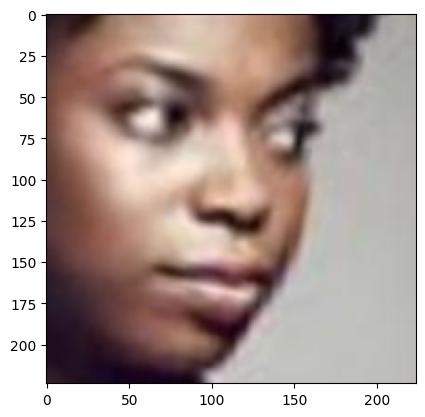

In [ ]:
if logger:
    plt.imshow (train_data[0][0].permute(1, 2, 0))

In [ ]:
def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in loader:
        # Flatten the images into (B, C, H*W) and compute stats
        images = images.view(images.size(0), images.size(1), -1)
        mean += images.mean(2).sum(0)  # Sum mean per channel
        std += images.std(2).sum(0)  # Sum std per channel
        total_samples += images.size(0)

    mean /= total_samples
    std /= total_samples
    return mean.numpy().tolist(), std.numpy().tolist()


In [ ]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

mean, std = calculate_mean_std(train_loader)
train_data.transform.transforms.append(transforms.Normalize(mean, std))
val_data.transform.transforms.append(transforms.Normalize(mean, std))
test_data.transform.transforms.append(transforms.Normalize(mean, std))

num_workers = os.cpu_count() if logger else int(os.getenv('SLURM_CPUS_PER_TASK', 1))

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
valid_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
if logger:
    print(f'Batches: {len(train_loader)}')
    print(f'Mean: {mean}')
    print(f'Std: {std}')


Batches: 130
Mean: [0.5953114032745361, 0.4555889666080475, 0.38978686928749084]
Std: [0.21820083260536194, 0.19405296444892883, 0.18496425449848175]


## Train and Eval Functions

In [ ]:
def train(model, optimizer, scheduler, criterion, train_loader, valid_loader, filename, device, n_epochs=5):
    train_loss_list, valid_loss_list = [], []
    train_acc_list, valid_acc_list = [], []

    start = datetime.now()

    for e in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        correct_train = 0
        total_train = 0

        model.train()

        # get batch data

        for images, targets in train_loader:

            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad() # clear grad
            outputs = model(images) # feedforward data
            loss = criterion(outputs, targets) # calculate loss
            loss.backward() # backward pass, calculate gradients
            optimizer.step() # update weights
            train_loss += loss.item() # track loss

            # Accumulate correct predictions for training accuracy
            preds = torch.argmax(outputs, dim=1)  # Get class predictions
            correct_train += (preds == targets).sum().item()
            total_train += targets.size(0)

        # Calculate training accuracy for the epoch
        train_acc = correct_train / total_train
        train_acc_list.append(train_acc)

        correct_valid = 0
        total_valid = 0
        # set model to evaluation mode
        model.eval()

        # validate model
        with torch.no_grad(): # turn off gradients
            for images, targets in valid_loader:
                images, targets = images.to(device), targets.to(device)

                outputs = model(images)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()

                # Accumulate correct predictions for validation accuracy
                preds = torch.argmax(outputs, dim=1)  # Get class predictions
                correct_valid += (preds == targets).sum().item()
                total_valid += targets.size(0)

        # Calculate validation accuracy for the epoch
        valid_acc = correct_valid / total_valid
        valid_acc_list.append(valid_acc)

        # get average loss values
        train_loss = train_loss / len(train_loader)
        valid_loss = valid_loss / len(valid_loader)

        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)

        scheduler.step(valid_loss)

        # output training statistics for epoch
        if logger:
            print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f} \t Training Accuracy: {:.2f}% \t Validation Accuracy: {:.2f}%'
                      .format((e + 1), train_loss, valid_loss, train_acc * 100, valid_acc * 100))

    time_taken = (datetime.now() - start)
    if logger:
        print ('\n')
        print(f'Training time: {time_taken/60} minutes')
    torch.save(model.state_dict(),f'{path}saved_models/{filename}.pt') # save model
    return train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, time_taken

In [ ]:
def plot_loss(train_loss_list, valid_loss_list, filename):
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    x = list(range(1, n_epoch + 1))
    plt.plot(x, train_loss_list, color ="blue", label='Train')
    plt.plot(x, valid_loss_list, color="orange", label='Validation')
    plt.legend(loc="upper right")
    plt.xticks(x)

    plt.savefig(f'{path}saved_plots/{filename}_loss.png', dpi=300)
    if logger:
        plt.show()
    else:
        plt.close()

In [ ]:
def plot_acc(train_acc_list, valid_acc_list, filename):
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    x = list(range(1, n_epoch + 1))
    plt.plot(x, train_acc_list, color ="blue", label='Train')
    plt.plot(x, valid_acc_list, color="orange", label='Validation')
    plt.legend(loc="upper right")
    plt.xticks(x)

    plt.savefig(f'{path}saved_plots/{filename}_acc.png', dpi=300)
    if logger:
        plt.show()
    else:
        plt.close()

In [ ]:
def eval_model(model, test_loader, criterion, device):
    start = datetime.now()
    model.eval()  # prepare model for evaluation

    test_loss = 0.0
    accuracy = 0

    n_class = len(classes)  # number of classes
    class_correct = torch.zeros(n_class, device=device)
    class_total = torch.zeros(n_class, device=device)
    with torch.no_grad():
    # test model
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

            # get correct predictions
            correct_preds = (preds == targets).float().to(device)

            # calculate and accumulate accuracy
            accuracy += torch.mean(correct_preds).item() * 100

            # calculate test accuracy for each class
            for c in range(n_class):
                class_total[c] += (targets == c).sum().item()
                class_correct[c] += ((correct_preds) * (targets == c)).sum().item()

    time_taken = (datetime.now() - start)
    if logger:
        print('\n')
        print(f'Inference time: {time_taken/ 60} minutes')

    accuracy = accuracy / len(test_loader)  # get average accuracy
    test_loss = test_loss / len(test_loader)  # get average loss
    # output test loss statistics
    if logger:
        print('Test Loss: {:.6f}'.format(test_loss))
        print('Accuracy : {:.6f}'.format(accuracy))
        print()

    class_accuracy = class_correct / class_total
    if logger:
        print('Test Accuracy of Classes')
        print()
        for c in range(n_class):
            print('{}\t: {}% \t ({}/{})'.format(classes[c],
                                                int(class_accuracy[c] * 100), int(class_correct[c]), int(class_total[c])))
        print()
        print('Test Accuracy of Dataset: \t {}% \t ({}/{})'.format(int(accuracy),
                                                                  int(torch.sum(class_correct)), int(torch.sum(class_total))))

    return test_loss, accuracy, class_accuracy, time_taken


## Define Models

In [ ]:
# hyper parameter
learning_rate =  params.loc[row, 'learning_rate']

# number of epoch
n_epoch = params.loc[row, 'n_epoch']

weight_decay = params.loc[row, 'weight_decay']
drop_out_rate = params.loc[row, 'drop_out']

filename = params.loc[row, 'filename']
temp = filename.split('_')
model_type = '_'.join(temp[:-1])
features = 768 if temp[1] == 'b' else 1024

In [ ]:
model_configs = {
    "vit_b_16": {"weights": models.ViT_B_16_Weights.DEFAULT},
    "vit_b_32": {"weights": models.ViT_B_32_Weights.DEFAULT},
    "vit_l_16": {"weights": models.ViT_L_16_Weights.DEFAULT},
    "vit_l_32": {"weights": models.ViT_L_32_Weights.DEFAULT},
}


# model = models.vit_b_16(dropout=drop_out_rate).to(device)
# model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT, dropout=drop_out_rate).to(device)

# Select weights (pretrained or None)
selected_model_config = model_configs[model_type]
weights = selected_model_config["weights"] if pretrained else None

# Dynamically initialize the model
model_class = getattr(models, model_type)  # Dynamically get the model class
model = model_class(weights=weights, dropout=drop_out_rate).to(device)

# change the number of output classes
model.heads = nn.Linear(in_features=features, out_features=len(classes), bias=True).to(device)

# freeze the parameters except the last linear layer
for p in model.parameters():
    p.requires_grad = False if pretrained else True
for p in model.heads.parameters():
    p.requires_grad = True

# specify loss function
criterion = nn.CrossEntropyLoss()

# only train the parameters with requires_grad set to True
optimizer = optim.Adam(filter(lambda p: p.requires_grad,
                              model.parameters()),
                       lr=learning_rate,
                       weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',          # Minimize validation loss
    factor=0.1,          # Default is fine for gradual LR reduction
    patience=n_epoch//5,
    verbose=True,        # Log when LR changes
    threshold=1e-4,      # Default for small improvements
    threshold_mode='rel',# Relative to the previous best
    cooldown=0,          # No delay after reduction
    min_lr=1e-6          # Prevent LR from getting too small
)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Run


In [ ]:
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, time_taken = train(model,
                                                                                     optimizer,
                                                                                     scheduler,
                                                                                     criterion,
                                                                                     train_loader,
                                                                                     valid_loader,
                                                                                     filename,
                                                                                     device,
                                                                                     n_epochs=n_epoch)

Epoch: 1 	 Training Loss: 1.655719 	 Validation Loss: 1.437539 	 Training Accuracy: 40.92% 	 Validation Accuracy: 42.77%
Epoch: 2 	 Training Loss: 1.448921 	 Validation Loss: 1.438552 	 Training Accuracy: 42.79% 	 Validation Accuracy: 43.19%
Epoch: 3 	 Training Loss: 1.444840 	 Validation Loss: 1.463851 	 Training Accuracy: 42.95% 	 Validation Accuracy: 43.19%
Epoch: 4 	 Training Loss: 1.430756 	 Validation Loss: 1.400068 	 Training Accuracy: 43.74% 	 Validation Accuracy: 44.71%
Epoch: 5 	 Training Loss: 1.404196 	 Validation Loss: 1.364736 	 Training Accuracy: 44.71% 	 Validation Accuracy: 45.47%
Epoch: 6 	 Training Loss: 1.385433 	 Validation Loss: 1.349391 	 Training Accuracy: 45.30% 	 Validation Accuracy: 46.20%
Epoch: 7 	 Training Loss: 1.367960 	 Validation Loss: 1.360377 	 Training Accuracy: 45.91% 	 Validation Accuracy: 47.64%
Epoch: 8 	 Training Loss: 1.379919 	 Validation Loss: 1.366234 	 Training Accuracy: 45.38% 	 Validation Accuracy: 45.73%
Epoch: 9 	 Training Loss: 1.3688

In [ ]:
torch.cuda.empty_cache()
refresh = False
if refresh:
    model = models.vit_b_16()
    model.load_state_dict(torch.load(f'{path}saved_models/{filename}.pt'))
    model = model.to(device)

In [ ]:
test_loss, accuracy, class_accuracy, inference_time = eval_model(model, test_loader, criterion, device)



Inference time: 0:00:00.250970 minutes
Test Loss: 1.263159
Accuracy : 50.302223

Test Accuracy of Classes

White	: 88% 	 (1321/1494)
Black	: 50% 	 (353/700)
Asian	: 17% 	 (92/514)
Indian	: 3% 	 (24/607)
Others	: 0% 	 (0/242)

Test Accuracy of Dataset: 	 50% 	 (1790/3557)


In [ ]:
with open(f'{path}results.csv', 'a') as f:
    results = [filename, time_taken, inference_time,
               train_loss_list[-1], valid_loss_list[-1], test_loss,
               train_acc_list[-1], valid_acc_list[-1],accuracy]
    results += list(class_accuracy.cpu().numpy())
    f.write(','.join(map(str, results)))
    f.write('\n')

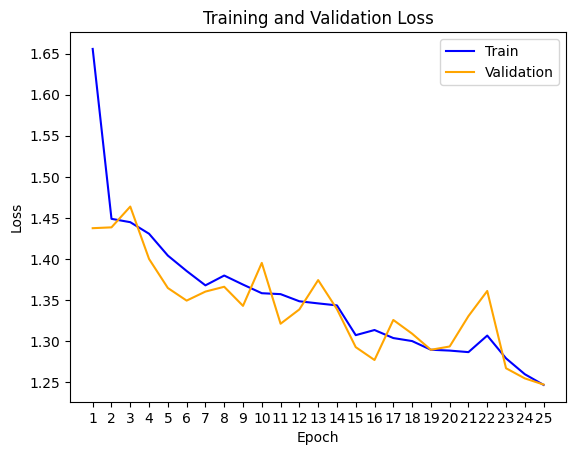

In [ ]:

plot_loss(train_loss_list, valid_loss_list, filename)

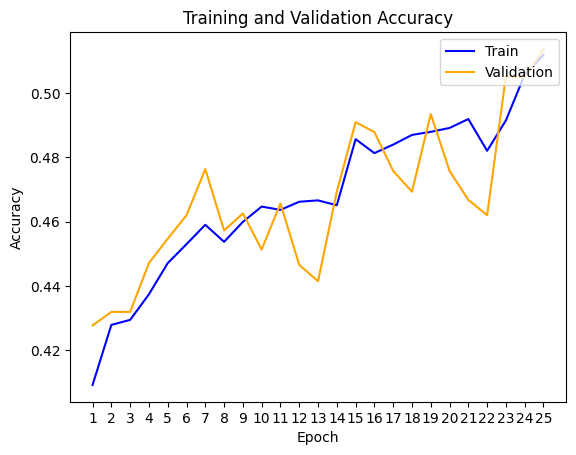

In [ ]:

plot_acc(train_acc_list, valid_acc_list, filename)